# Figure 3: Declining radial profile of Magellanic Corona.


In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
#Load Data
with open("Data/HIGH_ION_MAP_DATA.pkl", "rb") as f:
    high_ion_data = pickle.load(f)

In [3]:
high_ion_data.keys()

dict_keys(['LMC_COORD', 'SOURCE_COORDS', 'b', 'v', 'CIV', 'CIV_err', 'CIV_UL', 'SiIV', 'SiIV_err', 'SiIV_UL', 'stream_Bs', 'bridge_Bs'])

In [4]:
high_ion_data["b"]

array([ 6.73809061, 35.27897738, 34.84783719,  5.58284311, 13.82286391,
       42.69080167,  7.91413419, 13.02869289, 11.56735637, 42.86609215,
        6.76101035, 15.58367648, 17.97987862,  3.24829491, 12.48654041,
       26.54503213,  9.86112393, 22.20024646, 35.59066612, 15.92866702,
       37.41096327, 37.04679733, 39.37082432,  8.0715409 , 31.35142973,
       15.87299632, 46.05462368, 25.29519037])

In [5]:
# Prepare Data for Stat Tests

XX = high_ion_data["b"]

no_meas = np.isnan(high_ion_data["SiIV"])
no_meas = np.isnan(high_ion_data["SiIV_err"])
no_meas |= np.isinf(high_ion_data["SiIV"])

YY = np.copy(high_ion_data["SiIV"])
YY_err = np.copy(high_ion_data["SiIV_err"])
has_UL = np.isnan(high_ion_data["SiIV_UL"]) | np.isinf(high_ion_data["SiIV_UL"])
has_UL = np.invert(has_UL)
meas_S = ~no_meas
YY[no_meas] = high_ion_data["SiIV_UL"][no_meas]
YY_err[no_meas & has_UL] = -1.

good_vals = has_UL | ~no_meas


Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL & no_meas] = 1

Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xS = XX[good_vals]
yS = YY[good_vals]
yS_err = YY_err[good_vals]
xlimS = Xlim[good_vals]
ylimS = Ylim[good_vals]

kwargs = {"return_dist":True}

# Correlation Test for Si
res = pymccorrelation(xS, yS, xlim = xlimS, ylim = ylimS, 
            coeff = coeff, Nboot = Nboot, **kwargs)


out = {}

out["coeff_percentiles"] = res[0]
out["p-value_percentiles"] = res[1]
out["coeff_dist"] = res[2]
out["p-value_dist"] = res[3]




no_meas = np.isnan(high_ion_data["CIV"])
no_meas = np.isnan(high_ion_data["CIV_err"])
no_meas |= np.isinf(high_ion_data["CIV"])
meas_C = ~no_meas

YY = np.copy(high_ion_data["CIV"])
YY_err = np.copy(high_ion_data["CIV_err"])
has_UL = np.isnan(high_ion_data["CIV_UL"]) | np.isinf(high_ion_data["CIV_UL"])
has_UL = np.invert(has_UL)
YY[no_meas] = high_ion_data["CIV_UL"][no_meas]
YY_err[no_meas & has_UL] = -1.

good_vals = has_UL | ~no_meas


Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL&no_meas] = 1

Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xC = XX[good_vals]
yC = YY[good_vals]
yC_err = YY_err[good_vals]
xlimC = Xlim[good_vals]
ylimC = Ylim[good_vals]

kwargs = {"return_dist":True}


# Correlation Test for C
res = pymccorrelation(xC, yC, xlim = xlimC, ylim = ylimC, 
            coeff = coeff, Nboot = Nboot, **kwargs)


outC = {}

outC["coeff_percentiles"] = res[0]
outC["p-value_percentiles"] = res[1]
outC["coeff_dist"] = res[2]
outC["p-value_dist"] = res[3]


mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(out["coeff_dist"]),["CIV"]*len(outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([out["coeff_dist"], outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([out["p-value_dist"], outC["p-value_dist"]]))
}






In [6]:
# Correlation Test for points with rho>7 kpc

gt7_maskC = xC>7
gt7_resC = pymccorrelation(xC[gt7_maskC], yC[gt7_maskC], 
                           xlim = xlimC[gt7_maskC], ylim = ylimC[gt7_maskC], 
            coeff = coeff, Nboot = Nboot, **kwargs)

gt7_maskS = xS>7
gt7_resS = pymccorrelation(xS[gt7_maskS], yS[gt7_maskS], 
                           xlim = xlimS[gt7_maskS], ylim = ylimS[gt7_maskS], 
            coeff = coeff, Nboot = Nboot, **kwargs)

In [7]:
gt7_outC = {}

gt7_outC["coeff_percentiles"] = gt7_resC[0]
gt7_outC["p-value_percentiles"] = gt7_resC[1]
gt7_outC["coeff_dist"] = gt7_resC[2]
gt7_outC["p-value_dist"] = gt7_resC[3]

gt7_out = {}

gt7_out["coeff_percentiles"] = gt7_resS[0]
gt7_out["p-value_percentiles"] = gt7_resS[1]
gt7_out["coeff_dist"] = gt7_resS[2]
gt7_out["p-value_dist"] = gt7_resS[3]



gt7_mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(gt7_out["coeff_dist"]),["CIV"]*len(gt7_outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([gt7_out["coeff_dist"], gt7_outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([gt7_out["p-value_dist"], gt7_outC["p-value_dist"]]))
}

In [8]:
# Specify Bridge and Stream Directions

sn = ['PKS0637-75',
 'HE0246-4101',
 'RBS144',
 'PKS0552-640',
 'PKS0202-76',
 'HE0003-5023',
 'UVQSJ045415.95-611626.6',
 'HE0419-5657',
 'UKS0242-724',
 'IRAS_F21325-6237',
 'IRAS_Z06229-6434',
 'RBS567',
 'PKS0558-504',
 'RX_J0503.1-6634',
 '1H0419-577',
 'RBS1992',
 'ESO031-G08',
 'PKS0355-483',
 'HE0153-4520',
 'HE0439-5254',
 'HE0038-5114',
 'HE0226-4110',
 'HE2336-5540',
 'RBS563',
 'HE0331-4112',
 'HE0435-5304',
 'HE2305-5315',
 'FAIRALL9']


bridge_directions = [
    "PKS0202-76",
    "UKS0242-724",
    "ESO031-G08"
]


stream_directions = [
    "RBS144",
    "HE0226-4110",
    "HE0153-4520",
    "FAIRALL9"
]

stream_mask = np.array([n in stream_directions for n in sn])
stream_Bs = XX[stream_mask]

bridge_mask = np.array([n in bridge_directions for n in sn])
bridge_Bs = XX[bridge_mask]

rest_mask = ~stream_mask & ~bridge_mask

In [9]:
# Linear Regression
## All Data

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC, yC, xsig_C, ysig_C, delta=delta_C, K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

xx = np.linspace(0,50,1000)
all_lines_C = np.array([m*xx + b for (m,b) in zip(slopes_C, yints_C)])

lo_line_C, med_line_C, hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
mean_line_C = mean_slope_C*xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS, yS, xsig_S, ysig_S, delta=delta_S, K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

xx = np.linspace(0,50,1000)
all_lines_S = np.array([m*xx + b for (m,b) in zip(slopes_S, yints_S)])

lo_line_S, med_line_S, hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
mean_line_S = mean_slope_S*xx + mean_yint_S

In [10]:
# Linear Regression
## rho > 7 kpc

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC[xC>7], yC[xC>7], xsig_C[xC>7], ysig_C[xC>7], delta=delta_C[xC>7], K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_C = np.array([m*gt7_xx + b for (m,b) in zip(slopes_C, yints_C)])

gt7_lo_line_C, gt7_med_line_C, gt7_hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
gt7_mean_line_C = mean_slope_C*gt7_xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS[xS>7], yS[xS>7], xsig_S[xS>7], ysig_S[xS>7], delta=delta_S[xS>7], K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_S = np.array([m*gt7_xx + b for (m,b) in zip(slopes_S, yints_S)])

gt7_lo_line_S, gt7_med_line_S, gt7_hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
gt7_mean_line_S = mean_slope_S*gt7_xx + mean_yint_S

## Figure 3

<IPython.core.display.Javascript object>


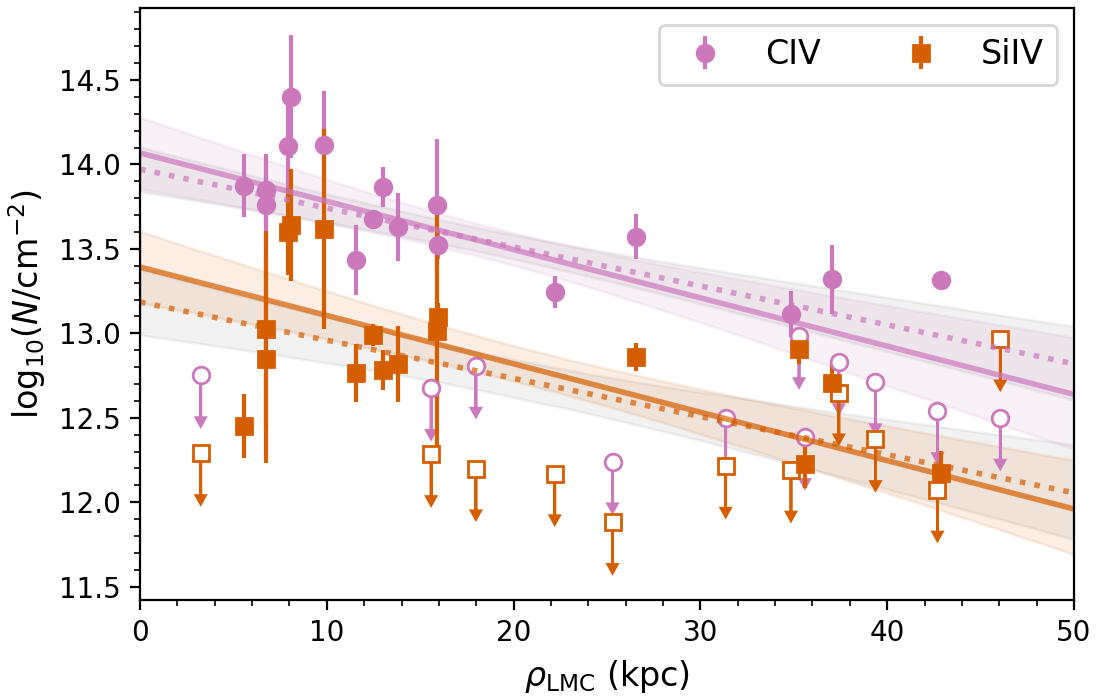

In [16]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0



axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
                  yC_err[~upper_lim_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
                  yS_err[~upper_lim_S], fmt = "s",
                  color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/Figure3.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/Figure3.svg", 
            transparent = True)

In [132]:
maximal_interface_obs = QTable.read("Data/MaxInterface_Cols.fits")

In [133]:
central_interface_obs = QTable.read("Data/CentralInterface_Cols.fits")

<IPython.core.display.Javascript object>


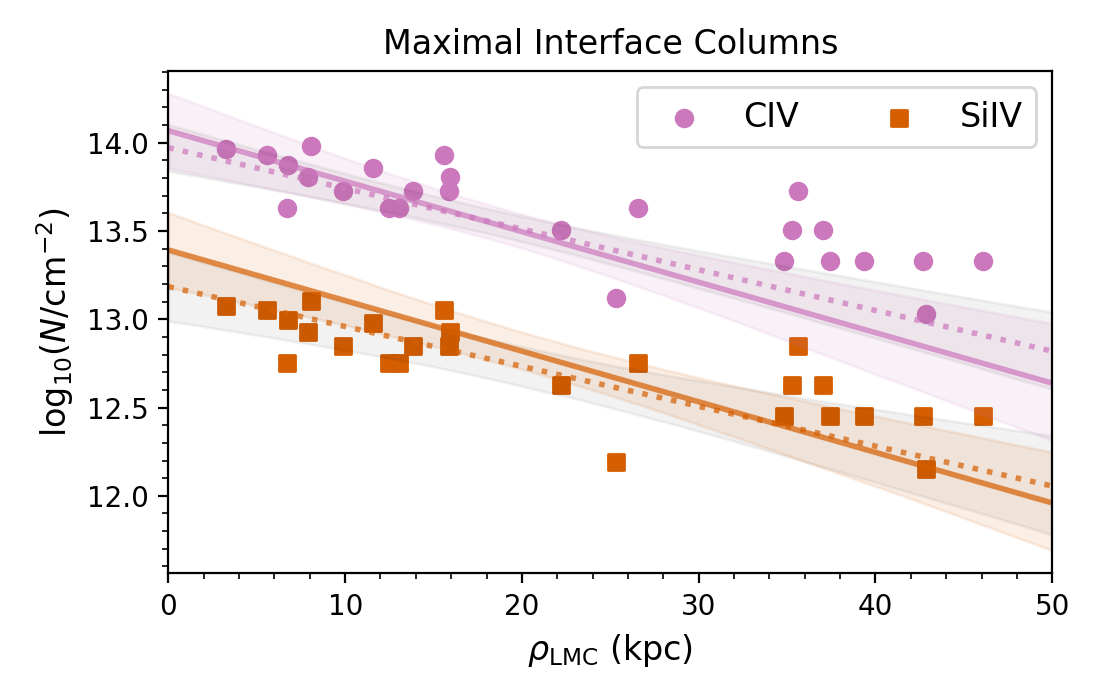

In [134]:
fig,ax = plt.subplots(figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0


ax.scatter(maximal_interface_obs["LMC_B"], np.log10(maximal_interface_obs["N_CIV"] * (10**-0.67/.1)*2), color = pal[4], 
           label = "CIV")

ax.scatter(maximal_interface_obs["LMC_B"], np.log10(maximal_interface_obs["N_SiIV"]* (10**-0.67/.1)*2), color = pal[3], 
           marker = "s", label = "SiIV")



# axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
#                  markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


# axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
#                  markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




# axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
#                   yC_err[~upper_lim_C], fmt = "o", 
#                   color=palette[1], label = "CIV")
# axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
#                   yS_err[~upper_lim_S], fmt = "s",
#                   color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

ax.set_title("Maximal Interface Columns")

fig.tight_layout()

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface.svg", transparent = True)


<IPython.core.display.Javascript object>


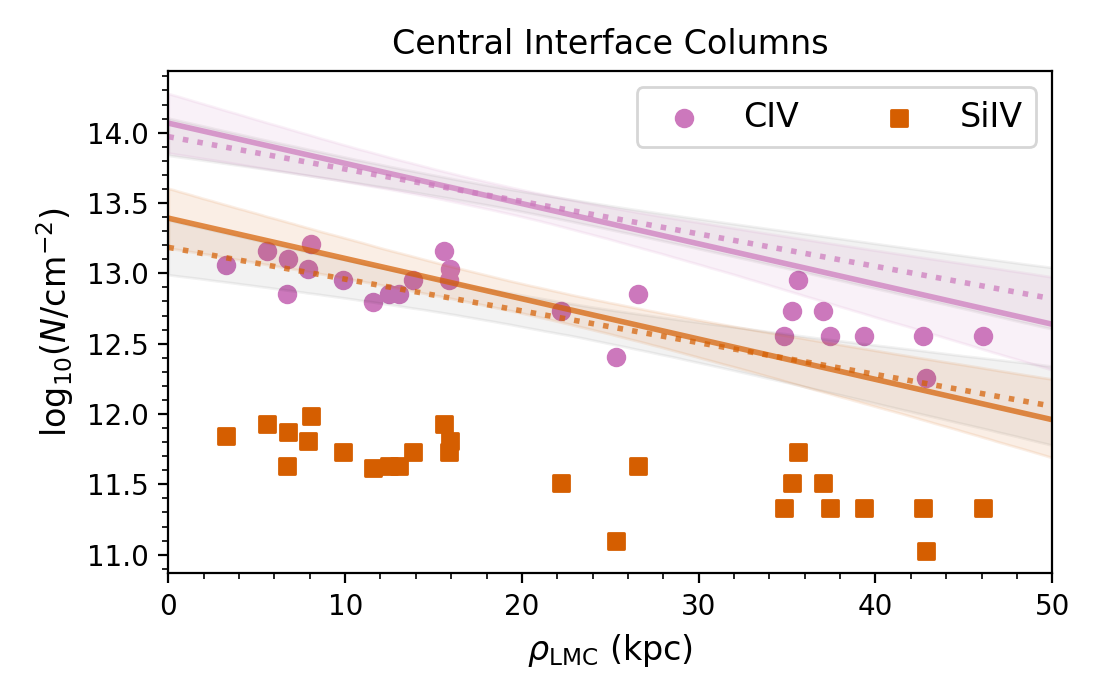

In [135]:
fig,ax = plt.subplots(figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0


ax.scatter(maximal_interface_obs["LMC_B"], np.log10(central_interface_obs["N_CIV"] * (10**-0.67/.1)*2), color = pal[4], 
           label = "CIV")

ax.scatter(maximal_interface_obs["LMC_B"], np.log10(central_interface_obs["N_SiIV"]* (10**-0.67/.1)*2), color = pal[3], 
           marker = "s", label = "SiIV")



# axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
#                  markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


# axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
#                  markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




# axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
#                   yC_err[~upper_lim_C], fmt = "o", 
#                   color=palette[1], label = "CIV")
# axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
#                   yS_err[~upper_lim_S], fmt = "s",
#                   color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

ax.set_title("Central Interface Columns")

fig.tight_layout()

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/CentralInterface.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/CentralInterface.svg", transparent = True)


In [136]:
matched_inds_C = [np.argmax(maximal_interface_obs["LMC_B"].value == b) for b in xC[~upper_lim_C]]

matched_inds_S = [np.argmax(maximal_interface_obs["LMC_B"].value == b) for b in xS[~upper_lim_S]]

C_interface_diff = yC[~upper_lim_C] - np.log10(maximal_interface_obs["N_CIV"][matched_inds_C] * 
                                               (10**-0.67/.1) * 2)

C_interface_diff_err = yC_err[~upper_lim_C]

Si_interface_diff = yS[~upper_lim_S] - np.log10(maximal_interface_obs["N_SiIV"][matched_inds_S] * 
                                               (10**-0.67/.1) * 2)

Si_interface_diff_err = yS_err[~upper_lim_S]

In [137]:
from scipy.stats import wilcoxon
from seaborn.algorithms import bootstrap

In [138]:
def boot_Cwilcoxon(inds, data_arr = C_interface_diff, 
                   errs = C_interface_diff_err):
    res = wilcoxon(data_arr[inds]+errs[inds]*np.random.randn(len(inds)), alternative = "greater")
    return [res.statistic, res.pvalue]
def boot_Siwilcoxon(inds, data_arr = Si_interface_diff, 
                   errs = Si_interface_diff_err):
    res = wilcoxon(data_arr[inds]+errs[inds]*np.random.randn(len(inds)), alternative = "greater")
    return [res.statistic, res.pvalue]


C_boot_wilcoxon = bootstrap(np.arange(len(C_interface_diff), dtype = int), 
                            func = boot_Cwilcoxon, 
                            nboot = 10000)

Si_boot_wilcoxon = bootstrap(np.arange(len(Si_interface_diff), dtype = int), 
                            func = boot_Siwilcoxon, 
                            nboot = 10000)

In [139]:
print(np.sum(Si_boot_wilcoxon[:,1] < .01)/1e4)
print(np.sum(C_boot_wilcoxon[:,1] < .01)/1e4)

0.0745
0.0087


In [140]:
np.percentile(C_boot_wilcoxon[:,1], (16,50,84))

array([0.16447449, 0.51838684, 0.84697723])

In [141]:
np.percentile(Si_boot_wilcoxon[:,1], (16,50,84))

array([0.02844238, 0.17643738, 0.51838684])

<IPython.core.display.Javascript object>


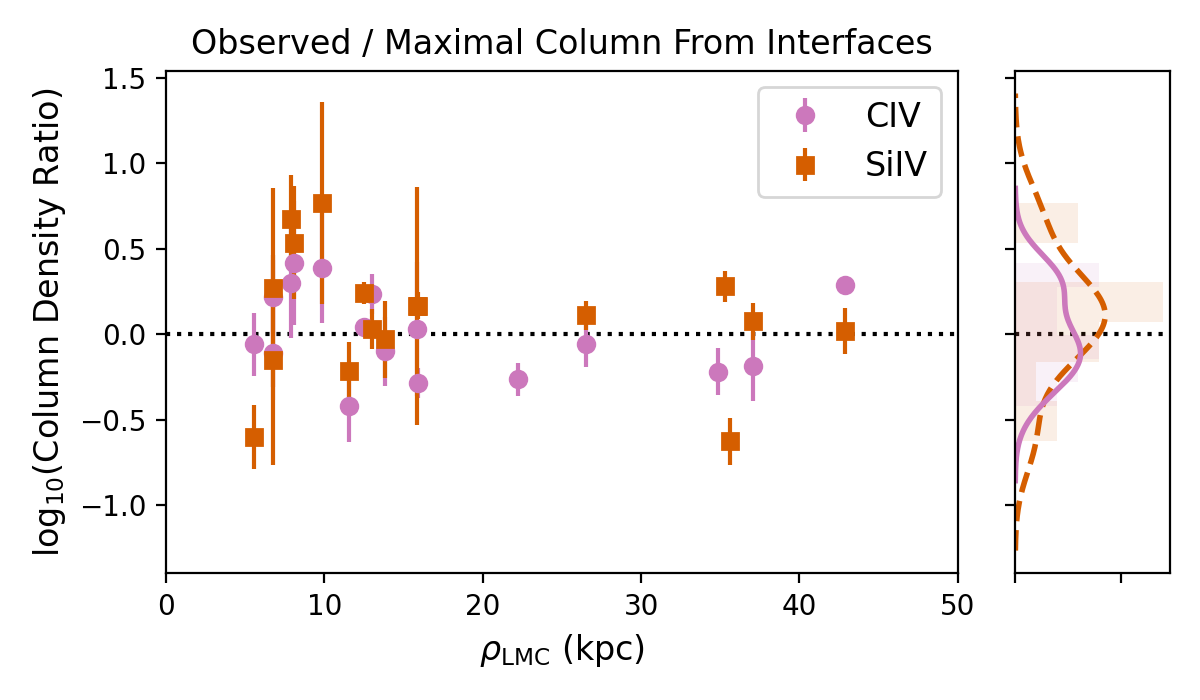

In [142]:
fig = plt.figure(figsize=(6,3.5))
gs = plt.GridSpec(5,5)

ax_joint = fig.add_subplot(gs[:, :-1])
        
ax_marg_y = fig.add_subplot(gs[:, -1], sharey=ax_joint)

plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)
plt.setp(ax_marg_y.get_xticklabels(minor=True), visible=False)

axd = {"A":ax_joint}

axd["A"].errorbar(xC[~upper_lim_C], C_interface_diff, 
                  C_interface_diff_err, fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S], Si_interface_diff, 
                  Si_interface_diff_err, fmt = "s",
                  color=palette[0], label = "SiIV")

axd["A"].axhline(0, ls = ":", color = "k", zorder = -1)

axd["A"].legend(fontsize = 12)


axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(\mathrm{Column~Density~Ratio})$", fontsize = 12)

axd["A"].set_title("Observed / Maximal Column From Interfaces", fontsize = 12)

sns.histplot(y = Si_interface_diff, color = palette[0], alpha = 0.1, kde = True, stat = "count",
            label = "SiIV", ax = ax_marg_y, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in ax_marg_y.lines] 

sns.histplot(y = C_interface_diff, color = palette[1], alpha = 0.1, kde = True, stat = "count",
            label = "CIV", ax = ax_marg_y, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth(2) for line in ax_marg_y.lines] 


ax_marg_y.axhline(0, ls = ":", color = "k", zorder = -1)

axd["A"].set_xlim(0,50)


fig.tight_layout()
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface_Diff.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface_Diff.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


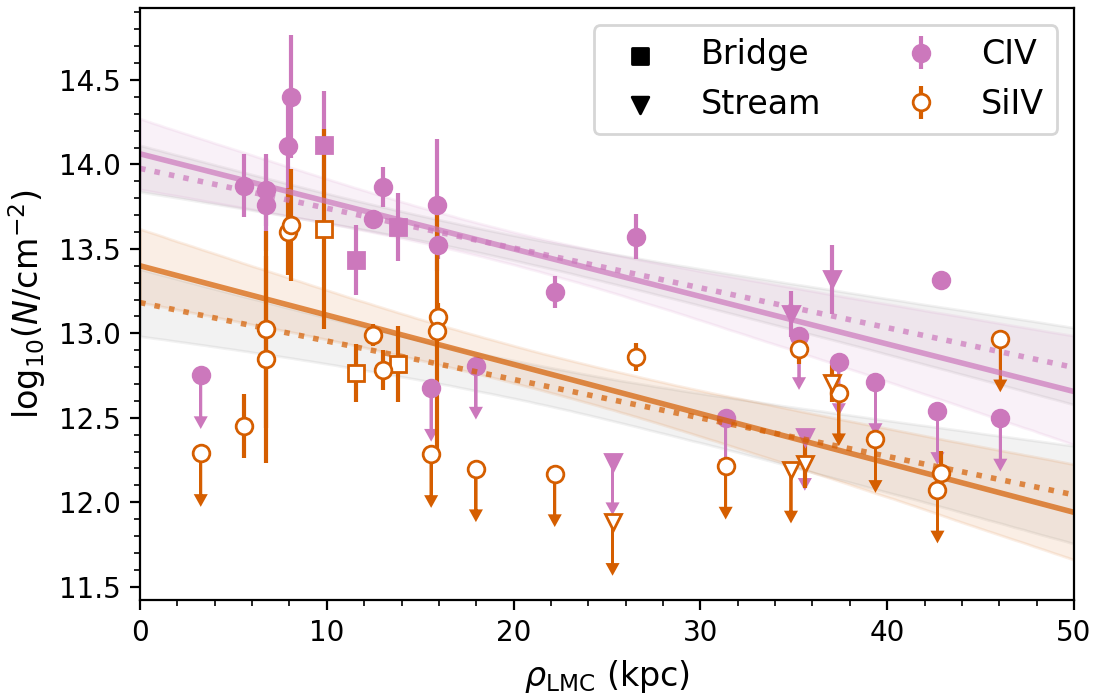

In [25]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

stream_S = np.array([x in stream_Bs for x in xS])
stream_C = np.array([x in stream_Bs for x in xC])

bridge_S = np.array([x in bridge_Bs for x in xS])
bridge_C = np.array([x in bridge_Bs for x in xC])

axd["A"].plot(xC[upper_lim_C & stream_C], yC[upper_lim_C & stream_C], "v",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xC[upper_lim_C & ~stream_C], yC[upper_lim_C & ~stream_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xS[upper_lim_S & stream_S], yS[upper_lim_S & stream_S], "v",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

axd["A"].plot(xS[upper_lim_S & ~stream_S], yS[upper_lim_S & ~stream_S], "o",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C & stream_C], yC[~upper_lim_C & stream_C], 
                  yC_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & stream_S], yS[~upper_lim_S & stream_S], 
                  yS_err[~upper_lim_S & stream_S], fmt = "v",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & bridge_C], yC[~upper_lim_C & bridge_C], 
                  yC_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & bridge_S], yS[~upper_lim_S & bridge_S], 
                  yS_err[~upper_lim_S & bridge_S], fmt = "s",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & ~stream_C & ~bridge_C], yC[~upper_lim_C & ~stream_C & ~bridge_C], 
                  yC_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S & ~stream_S & ~bridge_S], yS[~upper_lim_S & ~stream_S & ~bridge_S], 
                  yS_err[~upper_lim_S & ~stream_S & ~bridge_S], fmt = "o",
                  color=palette[0], label = "SiIV", mfc = "w")

axd["A"].scatter([20],[14.5], marker = "s", facecolor="k", edgecolor = "k", alpha = 0., label = "Bridge")
axd["A"].scatter([20],[14.5], marker = "v", facecolor="k", edgecolor = "k", alpha = 0., label = "Stream")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)



<IPython.core.display.Javascript object>


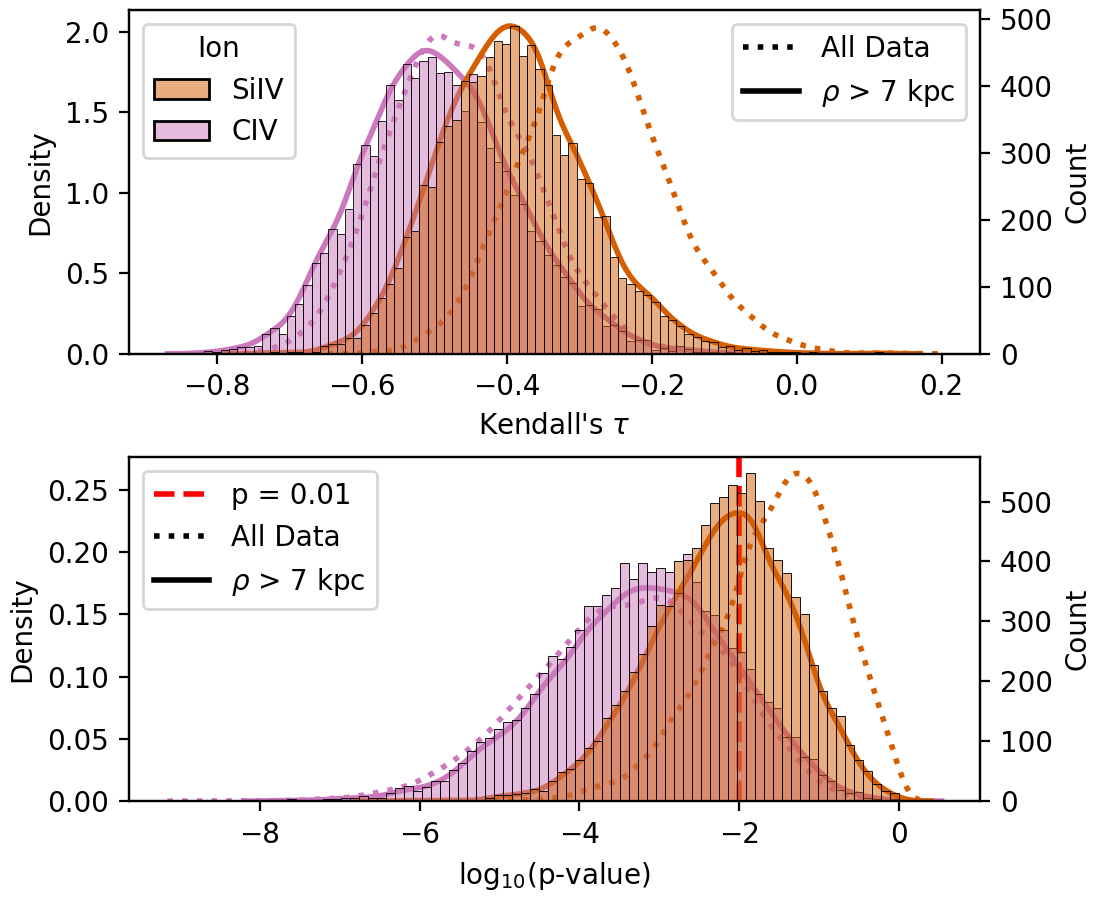

In [11]:
fig,axs = plt.subplots(2,1,constrained_layout = True, figsize = (5.5, 4.5))

axd = {"B":axs[0], "C":axs[1]}


palette = [pal[3], pal[4]]



sns.kdeplot(data = mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = ":", lw = 2)
sns.kdeplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = "-", lw = 2)

axt = axd["B"].twinx()
sns.histplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
             ax = axt, legend = True)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(axt, "upper left")

axd["B"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["B"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["B"].legend(loc = 1)
for lh in lg.legendHandles: 
    lh.set_alpha(1)



sns.kdeplot(data = mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = ":")
sns.kdeplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = "-")
axt2 = axd["C"].twinx()
sns.histplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
             ax = axt2, legend = False)

axd["C"].axvline(np.log10(0.01), ls = "--", color = "r", label = "p = 0.01", lw = 2)
axd["C"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["C"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["C"].legend(loc = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)


<IPython.core.display.Javascript object>


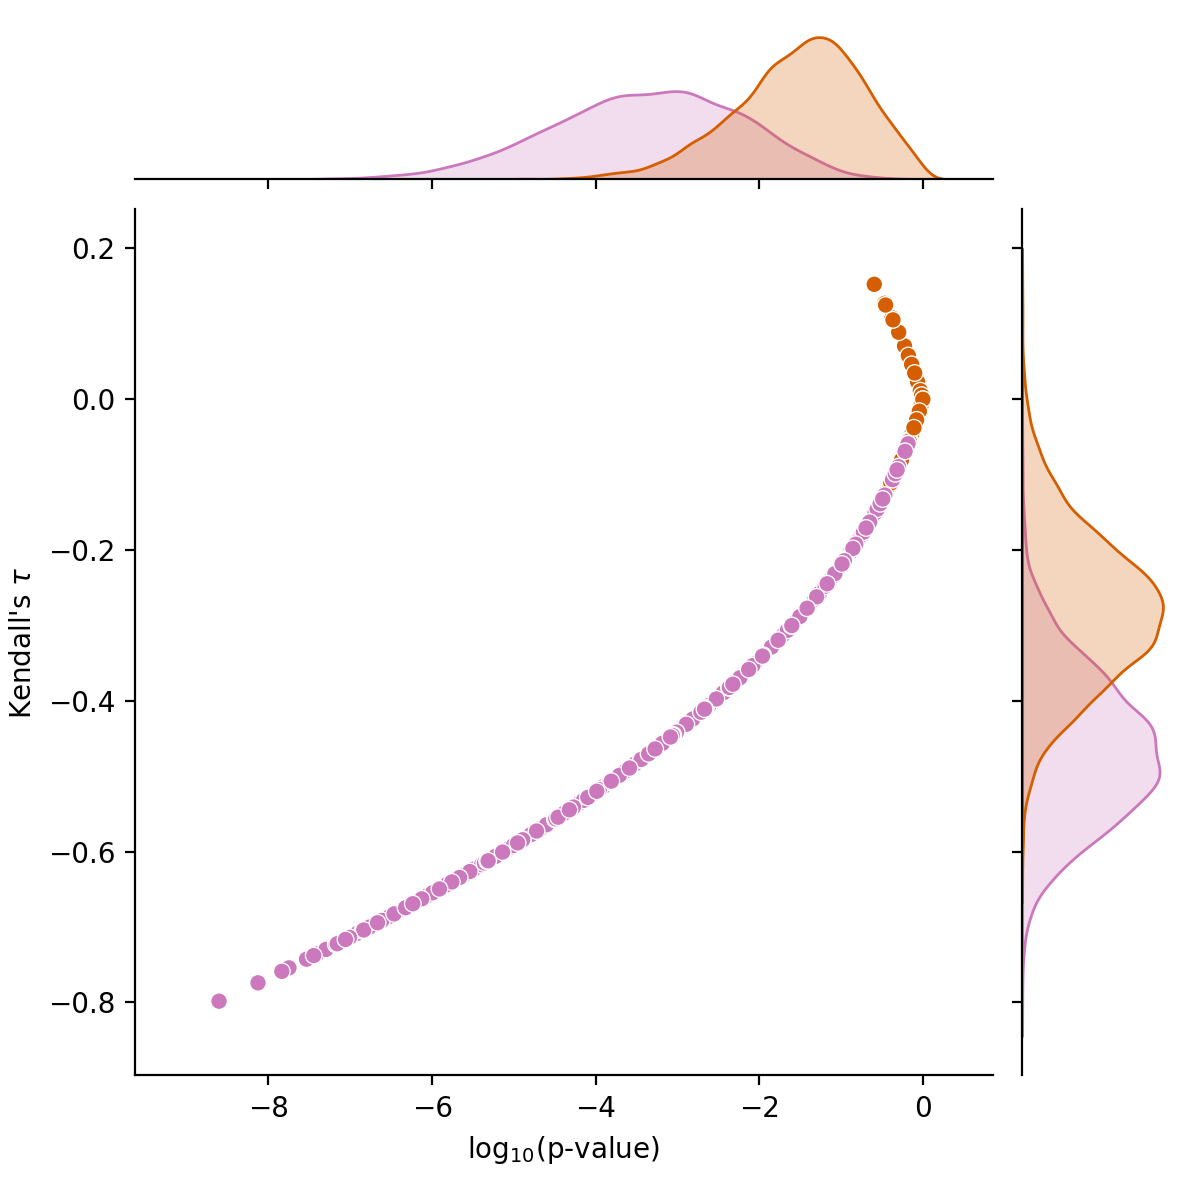

In [14]:
g = sns.jointplot(data = mc_data, hue = "Ion", palette = palette, 
            legend = False, 
                  y = r"Kendall's $\tau$", 
                  x = r"$\log_{10}$(p-value)", kind = "scatter")

<IPython.core.display.Javascript object>


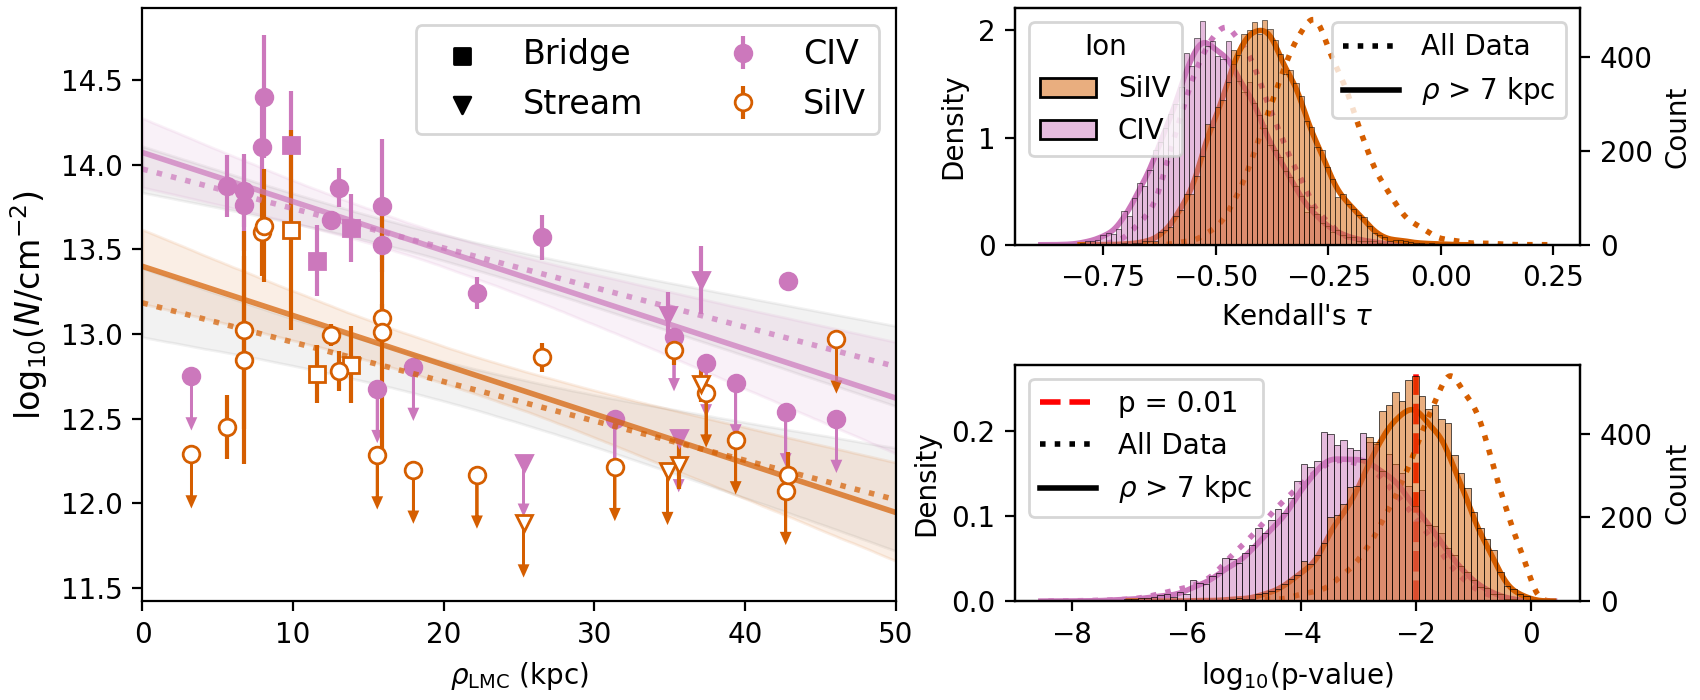

In [18]:
fig = plt.figure(constrained_layout = True, figsize = (8.5,3.5))



axd = fig.subplot_mosaic("""
AAAABBB
AAAACCC
""")

palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

stream_S = np.array([x in stream_Bs for x in xS])
stream_C = np.array([x in stream_Bs for x in xC])

bridge_S = np.array([x in bridge_Bs for x in xS])
bridge_C = np.array([x in bridge_Bs for x in xC])

axd["A"].plot(xC[upper_lim_C & stream_C], yC[upper_lim_C & stream_C], "v",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xC[upper_lim_C & ~stream_C], yC[upper_lim_C & ~stream_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xS[upper_lim_S & stream_S], yS[upper_lim_S & stream_S], "v",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

axd["A"].plot(xS[upper_lim_S & ~stream_S], yS[upper_lim_S & ~stream_S], "o",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C & stream_C], yC[~upper_lim_C & stream_C], 
                  yC_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & stream_S], yS[~upper_lim_S & stream_S], 
                  yS_err[~upper_lim_S & stream_S], fmt = "v",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & bridge_C], yC[~upper_lim_C & bridge_C], 
                  yC_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & bridge_S], yS[~upper_lim_S & bridge_S], 
                  yS_err[~upper_lim_S & bridge_S], fmt = "s",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & ~stream_C & ~bridge_C], yC[~upper_lim_C & ~stream_C & ~bridge_C], 
                  yC_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S & ~stream_S & ~bridge_S], yS[~upper_lim_S & ~stream_S & ~bridge_S], 
                  yS_err[~upper_lim_S & ~stream_S & ~bridge_S], fmt = "o",
                  color=palette[0], label = "SiIV", mfc = "w")

axd["A"].scatter([20],[14.5], marker = "s", facecolor="k", edgecolor = "k", alpha = 0., label = "Bridge")
axd["A"].scatter([20],[14.5], marker = "v", facecolor="k", edgecolor = "k", alpha = 0., label = "Stream")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)")
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)




sns.kdeplot(data = mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = ":", lw = 2)
sns.kdeplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = "-", lw = 2)

axt = axd["B"].twinx()
sns.histplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
             ax = axt, legend = True)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(axt, "upper left")

axd["B"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["B"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["B"].legend(loc = 1)
for lh in lg.legendHandles: 
    lh.set_alpha(1)



sns.kdeplot(data = mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = ":")
sns.kdeplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = "-")
axt2 = axd["C"].twinx()
sns.histplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
             ax = axt2, legend = False)

axd["C"].axvline(np.log10(0.01), ls = "--", color = "r", label = "p = 0.01", lw = 2)
axd["C"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["C"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["C"].legend(loc = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
# axd["C"].legend(fontsize = 10)

_ = axd["A"].set_xlim(0,50)
